In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [3]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [4]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

[0.73800804 0.74583691 0.75366577 0.76149464 0.7693235  0.77715237
 0.78498123 0.7928101  0.80063896 0.80846783 0.81629669 0.82412556
 0.83195442 0.83978329 0.84761215 0.85544102 0.86326988 0.87109875
 0.87892761 0.88675648 0.89458534 0.90241421 0.91024307 0.91807194
 0.9259008  0.93372967 0.94155853 0.9493874  0.95721626 0.96504513
 0.97287399 0.98070286 0.98853172 0.99636059 1.00418945 1.01201832
 1.01984718 1.02767605 1.03550491 1.04333378 1.05116264 1.05899151
 1.06682038 1.07464924 1.08247811 1.09030697 1.09813584 1.1059647
 1.11379357 1.12162243 1.1294513  1.13728016 1.14510903 1.15293789
 1.16076676 1.16859562 1.17642449 1.18425335 1.19208222 1.19991108
 1.20773995 1.21556881 1.22339768 1.23122654 1.23905541 1.24688427
 1.25471314 1.262542   1.27037087 1.27819973 1.2860286  1.29385746
 1.30168633 1.30951519 1.31734406 1.32517292 1.33300179 1.34083065
 1.34865952 1.35648838 1.36431725 1.37214611 1.37997498 1.38780384
 1.39563271 1.40346157 1.41129044 1.4191193  1.42694817 1.43477

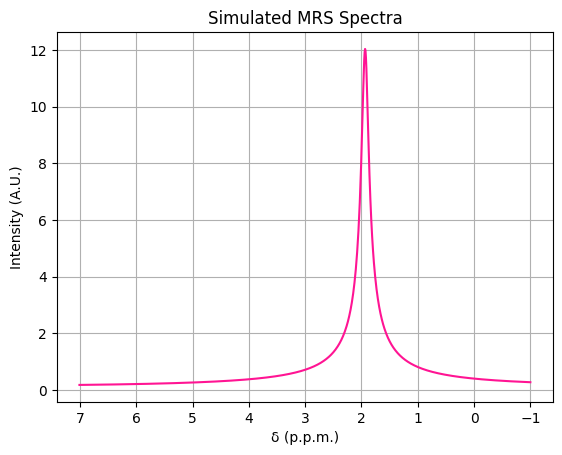

In [ ]:
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)
Delta = 1.2

select_arr = freqs <= pymri.chem_shift_from_f(pymri.rad_to_hz(ws[0]), B0) + Delta
select_arr = np.bitwise_and(select_arr, freqs > pymri.chem_shift_from_f(pymri.rad_to_hz(ws[0]), B0) - Delta)

In [5]:
snrs = np.array([500, 750, 1000, 2500, 5000, 7500, 10000, 25000, 50000])
print(snrs.size)
sigmas = pymri.snr_to_sigma(snrs)

9


In [6]:
L = 0.4
noise_threshold = 1e-30
L_ = int(L*sig.size)

In [9]:
print(pymri.chem_shift_from_f(pymri.rad_to_hz(ws), B0))

[1.9346]


In [23]:
c_sigs = np.zeros((snrs.size, sig.size), dtype = np.complex128)
r_sigs = np.zeros((snrs.size, sig.size), dtype = np.complex128)
residues = np.zeros((snrs.size, sig.size), dtype = np.complex128)
s0s = np.zeros((snrs.size, L_))
phis = np.zeros((snrs.size, L_))
omegas = np.zeros((snrs.size, L_))
t2s = np.zeros((snrs.size, L_))

for i in range(snrs.size):
    c_sigs[i, :] = pymri.corrupted_snr(sig, 0.0, sigmas[i])
    fil_sig, z, r = pymri.filter_sig(c_sigs[i, :], L, noise_threshold, return_full_arrays=True, return_poles_and_res=True)
    s0s[i, :], phis[i, :], omegas[i, :], t2s[i, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
    t2s[i, :] = 1/t2s[i, :]
    s0__, phi__, omega__, t2s__, n_comp = pymri.select_peaks(s0s[i, :], phis[i, :], omegas[i, :], t2s[i, :])
    r_sigs[i, :], t_ = pymri.population_transverse_decay(t0, tn, dt, pymri.population(omega__, t2s__, s0__, phi__))
    freqs, r_sigs[i, :] = pymri.fourier_spectrum(r_sigs[i, :], dt, B0)
    freqs, c_sigs[i, :] = pymri.fourier_spectrum(c_sigs[i, :], dt, B0)
    residues[i, :] = c_sigs[i, :] - r_sigs[i, :]

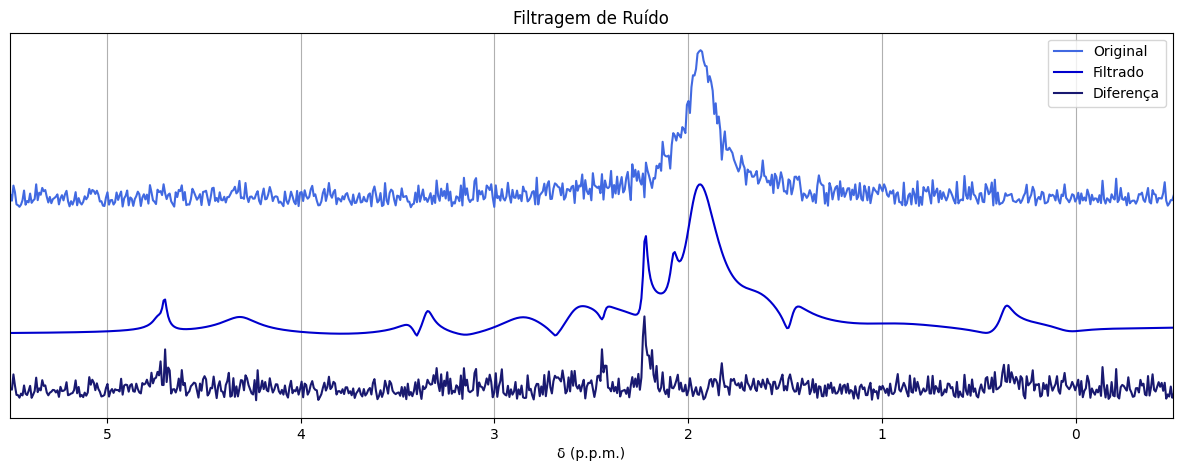

In [31]:
yoffset = 5.0
i = 0

plt.figure(figsize=(15, 5))

plt.plot(freqs, np.absolute(c_sigs[i, :]) + 3*yoffset, c = "royalblue", label = "Original")
plt.plot(freqs, np.absolute(r_sigs[i, :]) + yoffset, c = "mediumblue", label = "Filtrado")
plt.plot(freqs,  np.absolute(residues[i, :]), c = "midnightblue", label = "Diferença")
plt.xlim(-0.5, 5.5)
plt.title("Filtragem de Ruído")
plt.xlabel("δ (p.p.m.)")
# plt.ylabel("Intensidade (U.A.)")
plt.xlim(-0.5, 5.5)
plt.yticks([])
plt.legend()
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()